# Plotting predictions from models

In [1]:
import pickle
from revenue.model import TCN
import os
import argparse
import torch
#from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from revenue.data import RevenueDataset
import numpy as np
import pandas as pd
import datetime

### Styles

In [2]:
cluster_style = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}
ts_style = {
    "axes.spines.left": True,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": True,
    "ytick.left": True,
}
rc("text", usetex=True)

In [3]:
import os
os.getcwd()

'c:\\Users\\eriko\\OneDrive - NTNU\\ntnu\\fag\\prosjekt\\TCN'

In [4]:
#model_dir = "revenue\models"
model_dir = "Z:\TCN_clone\TCN\\revenue\models"
#model_names = ["test", "test_no_scale"]
model_names = [
    "9dd49918c3834dfd9916abd926f80e41", # base tcn
    "861ef425d8094ac4ab4f9d64a678e40e", # embed sector
    "066c0db6eb7c42b984f94b0f99839421", # embed + cluster
    ]

model_paths = [f"{os.path.join(model_dir, mn)}.pt" for mn in model_names]
model_paths
#Z:\TCN_clone\TCN\revenue\models\1ac6826c66f546af9e90ea6aac14aad3.pt__args

['Z:\\TCN_clone\\TCN\\revenue\\models\\9dd49918c3834dfd9916abd926f80e41.pt',
 'Z:\\TCN_clone\\TCN\\revenue\\models\\861ef425d8094ac4ab4f9d64a678e40e.pt',
 'Z:\\TCN_clone\\TCN\\revenue\\models\\066c0db6eb7c42b984f94b0f99839421.pt']

In [5]:
models = []
for i, MODEL_PATH in enumerate(model_paths):
    args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))
    print(args)
    model = TCN(
        num_layers=args.num_layers,
        in_channels=1 if i != 2 else 2,
        out_channels=1,
        residual_blocks_channel_size=[args.res_block_size]*args.num_layers,
        kernel_size=args.kernel_size,
        bias=args.bias,
        dropout=args.dropout,
        stride=1,
        leveledinit=args.leveledinit,
        embedding_dim=args.embedding_dim,
        embed=args.embed,
        dilated_convolutions=args.dilated_convolutions,
        clustering_dict=None,
        num_embeddings=13,
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    model.eval()
    models.append(model)

Namespace(N=100, bias=True, clip=True, cluster_covariate=False, cluster_dict_path='None', clustering='KMeans', data_scale=False, dilated_convolutions=False, dropout=0.2, embed=None, embed_sector=False, embedding_dim=3, epochs=100, h_batch_size=4, kernel_size=4, length_rolling=4, leveledinit=False, log_interval=300, lr=0.0005, mean=0, model_save_path='revenue/models/9dd49918c3834dfd9916abd926f80e41.pt', num_clusters=10, num_components=10, num_layers=3, num_rolling_periods=2, num_workers=4, one_hot_id=False, print=True, random_covariate=False, representation='pca', res_block_size=32, similarity='euclidean', stride=1, t=1000, tenacity=10, time_covariates=False, train_end='2017-01-01', train_start='2007-01-01', type_res_blocks='erik', v_batch_size=128, var=1.0, writer_path='revenue/runs/9dd49918c3834dfd9916abd926f80e41', zero_covariate=False)
[1, 1, 1]
Namespace(N=100, bias=True, clip=True, cluster_covariate=False, cluster_dict_path='None', clustering='KMeans', data_scale=False, dilated_co

## Dataset rolling val

In [22]:
ds_train = RevenueDataset(
        file_path="revenue/data/processed_companies.csv",
        meta_path="revenue/data/comp_sect_meta.csv",
        data_scale=False,
        data_scaler=None,
        start_date="2007-01-01",  # yyyy-mm-dd
        end_date="2017-01-01",  # yyyy-mm-dd,
        cluster_covariate=True,
        prototypes_file_path="Z:\TCN_clone\TCN\\prototypes\\prototypes_matrices\\revenue_sarima_unscaled__nc_30_euclidean_Spectral_clustering_nc_100.npy",
        cluster_dict_path="Z:\TCN_clone\TCN\\prototypes\\cluster_dicts\\revenue_sarima_unscaled_nc_30_euclidean_Spectral_clustering_nc_100.pkl"
)
ds_test = RevenueDataset(
        file_path="revenue/data/processed_companies.csv",
        meta_path="revenue/data/comp_sect_meta.csv",
        data_scale=False,
        data_scaler=ds_train.data_scaler,
        start_date="2013-12-31",  # yyyy-mm-dd
        end_date="2018-12-31",  # yyyy-mm-dd
        cluster_covariate=True,
        prototypes_file_path="Z:\TCN_clone\TCN\\prototypes\\prototypes_matrices\\revenue_sarima_unscaled__nc_30_euclidean_Spectral_clustering_nc_100.npy",
        cluster_dict_path="Z:\TCN_clone\TCN\\prototypes\\cluster_dicts\\revenue_sarima_unscaled_nc_30_euclidean_Spectral_clustering_nc_100.pkl"
)

Dimension of X :  torch.Size([15229, 1, 40])
Dimension of Y :  torch.Size([15229, 1, 40])
Dimension of X :  torch.Size([15229, 1, 21])
Dimension of Y :  torch.Size([15229, 1, 21])


In [23]:
from torch.utils.data import DataLoader
dl = DataLoader(dataset=ds_test, batch_size=15229, shuffle=False, num_workers=0)
x, y, idx, idx_row, sect = iter(dl).next()

In [30]:
ids = [16, 176, 316]#, 5000, 7000, 10000]
#model = models[0]
#mods = [models[1], models[3]]#, models[3]]
names = ["base", "embd", "cluster"]
two_channels = [False, False, True]
dfs = []
for i in ids:
    print("ID: ", i)
    d = {}
    with torch.no_grad():
        #print(ds_scaled.X[i].unsqueeze(1).shape)
        for j, model in enumerate(models):
            print(j)
            if two_channels[j]:
                preds, _ = model.rolling_prediction(x=x[:,:,:], emb_id=sect, tau=4, num_windows=2)
            else:
                preds, _ = model.rolling_prediction(x=x[:,0,:].unsqueeze(1), emb_id=sect, tau=4, num_windows=2)
            d[names[j]]=preds.detach().cpu().numpy()[i, -2*4:]
        real_values = ds_test.X[i, 0,  -2*4 :].detach().cpu().numpy()
        d["real"] = real_values
        df = pd.DataFrame(d)
        #df.index  = pd.date_range(start="2014-12-16", freq='H', periods=24*7)
        dfs.append(df)

ID:  16
0
1
2
ID:  176
0
1
2
ID:  316
0
1
2


In [26]:
# Add deepglo 860795	scale: FALSE	LI: TRUE
dglo_preds = np.load("Z:\TCN_clone\deepglo\predicted_values_revenue_f_t.npy")

In [31]:
for i, df in enumerate(dfs):
    df["dglo"] = dglo_preds[ids[i], -2*4:]
    print(df.head())

base        embd     cluster   real         dglo
0  129.636124  138.576370  147.896591   70.0   447.479706
1  156.254242  176.054626  154.309631  181.0   432.746277
2  164.464645  177.870010  156.736237  149.0   429.106659
3  224.170868  215.265045  189.309158  584.0   429.046051
4  141.334473  111.388008  151.875687  504.0  1000.871582
          base         embd      cluster    real         dglo
0  5528.880859  5420.359863  4948.303223  5352.0  5965.798340
1  5720.945312  5550.982910  5402.479980  5314.0  5932.710938
2  4991.673828  5150.093262  4684.803711  4537.0  6001.223633
3  6077.360352  6242.434570  5980.798828  6548.0  6113.976074
4  5413.068359  5566.605469  4885.727539  4887.0  6278.385742
         base        embd     cluster   real        dglo
0  304.708008  295.019928  296.235687  279.0  302.873962
1  310.778442  306.993896  304.493286  283.0  306.242554
2  317.762726  306.502228  296.598907  286.0  312.901611
3  322.306702  299.990753  292.653717  313.0  322.346741
4  3

base        embd     cluster   real         dglo
2017-03-31  129.636124  138.576370  147.896591   70.0   447.479706
2017-06-30  156.254242  176.054626  154.309631  181.0   432.746277
2017-09-30  164.464645  177.870010  156.736237  149.0   429.106659
2017-12-31  224.170868  215.265045  189.309158  584.0   429.046051
2018-03-31  141.334473  111.388008  151.875687  504.0  1000.871582
                   base         embd      cluster    real         dglo
2017-03-31  5528.880859  5420.359863  4948.303223  5352.0  5965.798340
2017-06-30  5720.945312  5550.982910  5402.479980  5314.0  5932.710938
2017-09-30  4991.673828  5150.093262  4684.803711  4537.0  6001.223633
2017-12-31  6077.360352  6242.434570  5980.798828  6548.0  6113.976074
2018-03-31  5413.068359  5566.605469  4885.727539  4887.0  6278.385742
                  base        embd     cluster   real        dglo
2017-03-31  304.708008  295.019928  296.235687  279.0  302.873962
2017-06-30  310.778442  306.993896  304.493286  283.0  306

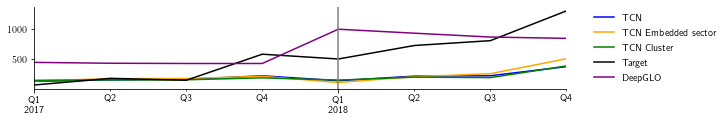

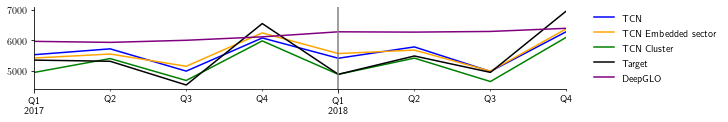

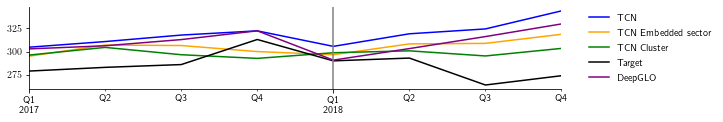

In [45]:
plot_length = 8
colors = ['blue', 'orange', 'green', 'black', 'purple']
with plt.style.context(ts_style):
    for i in range(len(ids)): 
        date_list = ds_test.dates.tolist()
        dfs[i].index = pd.to_datetime(date_list[-2*4:])
        print(dfs[i].head())
        ax = dfs[i][-plot_length:].plot(figsize=(2*4.77, 1.5), legend=names, color=colors)
        
        x = pd.to_datetime(['2018-03-31'])
        for xc in x:
            ax.axvline(x=xc, color='grey', linestyle='-')
        #x1, x2 = ax.get_xlim()
        #ax.set_xlim((x1, x2 + 1))
        ax.legend(["TCN", "TCN Embedded sector", "TCN Cluster", "Target" , "DeepGLO"], loc=7, frameon=False, bbox_to_anchor=(1.30, 0.5))
        plt.savefig(f"Figures\\revenue_all_pred_id_{ids[i]}.pdf", bbox_inches="tight")

# Embedding

In [3]:
model_dir = "Z:\TCN_clone\TCN\\revenue\models"
model_names = [
    "tcn_3_4_32_False_embed_True_dim_5",
]
model_paths = [f"{os.path.join(model_dir, mn)}" for mn in model_names]
model_paths

['Z:\\TCN_clone\\TCN\\revenue\\models\\tcn_3_4_32_False_embed_True_dim_5']

In [4]:
models = []
for MODEL_PATH in model_paths:
    #args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))
    model = TCN(
        num_layers=3,#args.num_layers,
        in_channels=1,
        out_channels=1,
        residual_blocks_channel_size=[32]*3,#[args.res_block_size]*args.num_layers,
        kernel_size=4,#args.kernel_size,
        bias=True,#args.bias,
        dropout=0.2,#args.dropout,
        stride=1,
        leveledinit=False,#args.leveledinit,
        num_embeddings=15299,
        embedding_dim=5,#args.embedding_dim,
        embed="post",#args.embed,
        dilated_convolutions=False
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    model.eval()
    models.append(model)
#print(models)

NameError: name 'TCN' is not defined

## Embedding layer of each model

In [5]:
embeddings = []
for model in models:
    ids = [i for i in range(370)]
    ids = torch.LongTensor(ids).to("cpu")
    embds = model.embedding(ids).detach().cpu().numpy()
    embeddings.append(embds)

## Visualize

In [6]:
with plt.style.context(cluster_style):
    for embedding in embeddings[:2]:
        nc = embedding.shape[1]
        if embedding.shape[1] > 2:
            tsne = TSNE(n_components=2)
            embedding = tsne.fit_transform(embedding)
        #plt.figure()
        #plt.scatter(embedding[:,0], embedding[:,1], c="#00B0F0", edgecolor="black", linewidth=0.5)
        #plt.title(f"Embedding dim {nc}")
        #plt.show()
#"colors = ["#FFC000", "#00B0F0"]ø

NameError: name 'plt' is not defined

In [7]:
size=4.77/3
with plt.style.context(cluster_style):
    plt.figure(figsize=(size, size))
    plt.scatter(embeddings[0][:,0], embeddings[0][:,1], s=20, c="#00B0F0", edgecolor="black", linewidth=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.axis('scaled')
    #plt.title(f"Embedding dim {nc}")
    plt.savefig("electricity_learned_embedding_2.pdf")#, bbox_inches="tight")
    for embedding in embeddings[:2]:
        nc = embedding.shape[1]
        tsne = TSNE(n_components=2)
        embedding = tsne.fit_transform(embedding)
        plt.figure(figsize=(size, size))
        plt.scatter(embedding[:,0], embedding[:,1], s=20, c="#00B0F0", edgecolor="black", linewidth=0.3)
        plt.xticks([])
        plt.yticks([])
        plt.axis('scaled')
        #plt.title(f"Embedding dim {nc}")
        plt.savefig(f"electricity_learned_embedding_{nc}_tsne.pdf")#, bbox_inches="tight")

NameError: name 'plt' is not defined